# Text Emotions Classification

### Text emotion classification is a fundamental task in the field of natural language processing and text classification. The objective is to develop a model that accurately identifies the emotion conveyed by a piece of text. This task has widespread applications, from chatbots and virtual assistants that need to understand user sentiment, to social media monitoring tools that track public opinion.

### To train a text classification model, we require labeled data of texts and their corresponding emotions. One such dataset that is widely used for this task is available on Kaggle, and can be easily downloaded for use.

### In this project, we aim to build a text classification model for text emotion classification using machine learning and the Python programming language.

## Text Emotions Classification using Python

### I’ll start by importing the necessary Python libraries and the dataset:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Flatten

import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Load test data, train data, and validation data

test_data = pd.read_csv("test.txt", sep=";", names=["Text","Emotion"])
train_data = pd.read_csv("train.txt", sep=";", names=["Text","Emotion"])
val_data = pd.read_csv("val.txt", sep=";", names=["Text","Emotion"])

In [3]:
# Print the first 5 rows of the train_data dataframe

train_data.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [4]:
# Print the number of null values in each column

train_data.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [5]:
# Print the dimensions (number of rows and columns) of the train_data dataframe

train_data.shape

(16000, 2)

In [6]:
# Returns an array of unique values in the 'Emotion' column

emo_list = train_data['Emotion'].unique()
emo_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

### Lets try to create a new feature that calculates the length of each text and visualizes the distribution of the 'Emotion' classes using a histogram.

### The purpose of this code is to explore the distribution of emotions in the dataset and gain insights. The histogram provides a visual representation of the frequency of each emotion class in the dataset, and the calculated length of each text could be used as a potential feature for the classification model.

<AxesSubplot:xlabel='Length', ylabel='Density'>

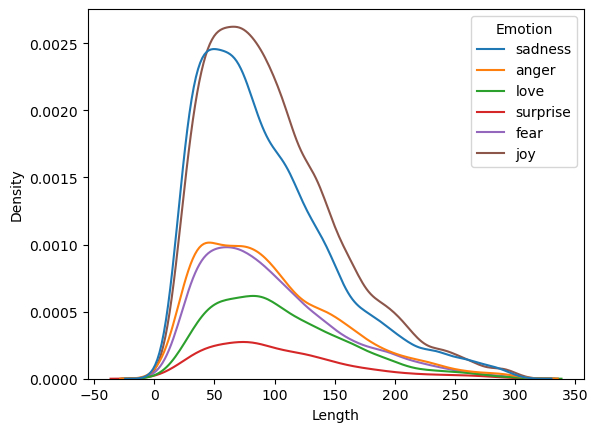

In [7]:
# Create new 'Length' column based on length of 'Text'. Plot kernel density estimate (KDE) for 'Length' by 'Emotion'

train_data["Length"] = [len(i) for i in train_data["Text"]]

sns.kdeplot(x=train_data["Length"], hue=train_data["Emotion"])

{'anger', 'surprise', 'fear', 'love', 'joy', 'sadness'}


<function matplotlib.pyplot.show(close=None, block=None)>

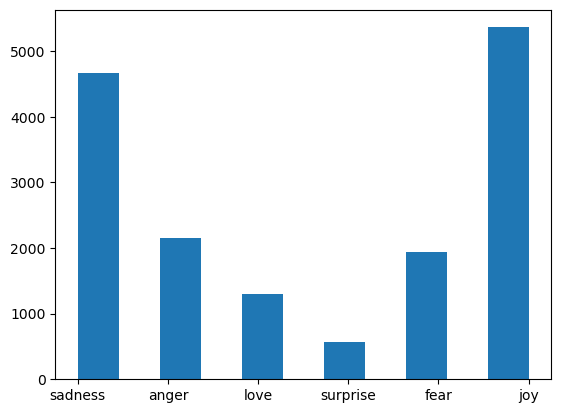

In [8]:
# Create a set of unique 'Emotion' classes in 'train_data'. Display the set of 'Emotion' classes and plot histogram

classes = set(train_data['Emotion'])
print(classes)
plt.hist(train_data['Emotion'],bins = 11)
plt.show

### In order to gain more insight into the language used in each emotion class, we create word clouds for each class. This allows us to visually explore the most common words associated with each emotion, providing potential insights into the language patterns and themes within the data.

In [9]:
# Function to create and display word cloud using matplotlib

def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

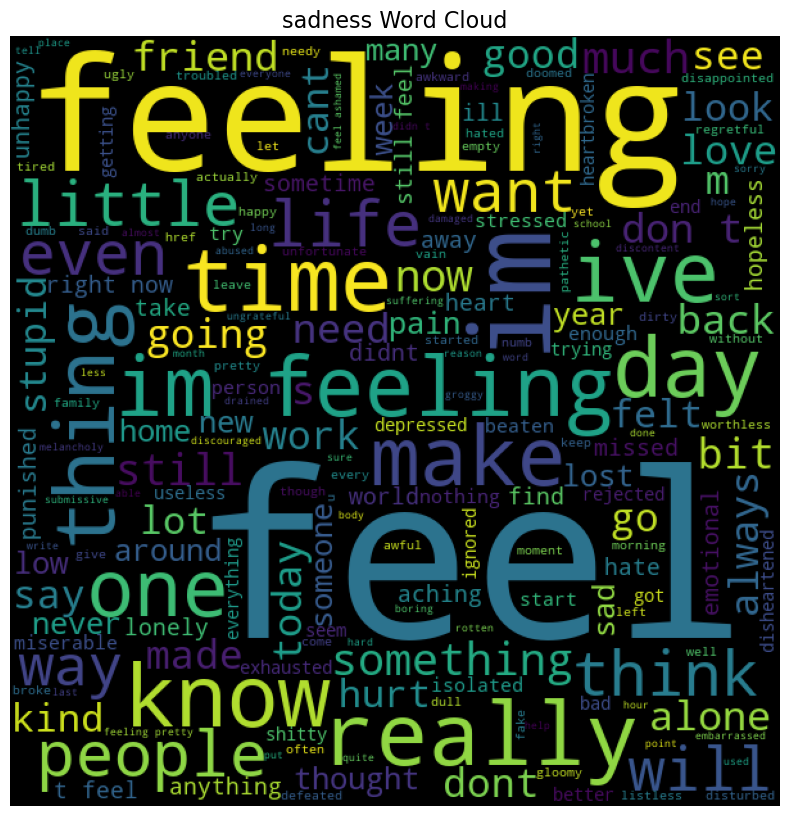

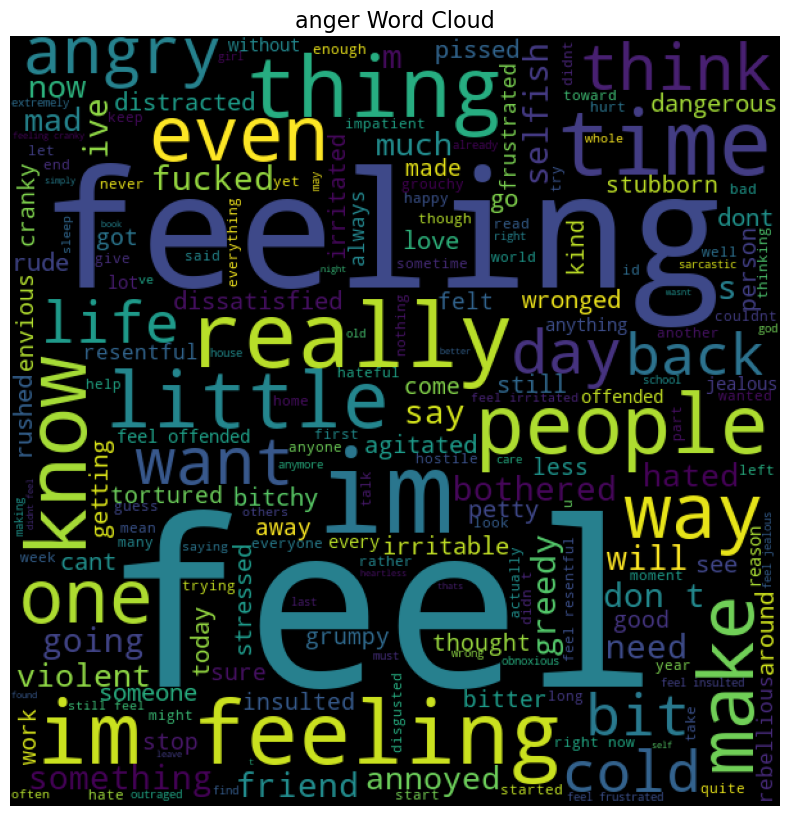

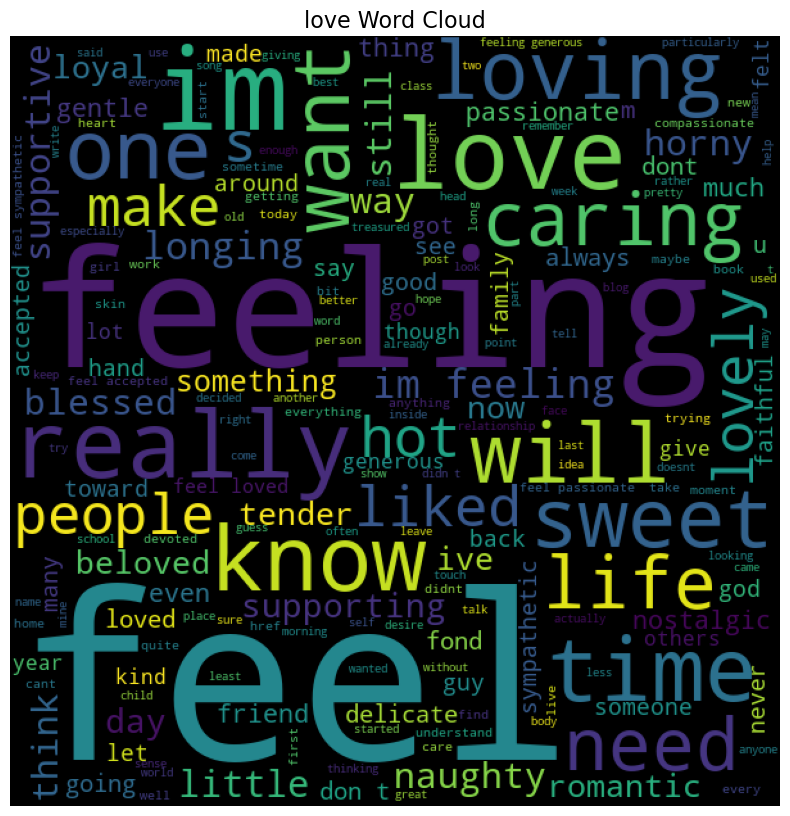

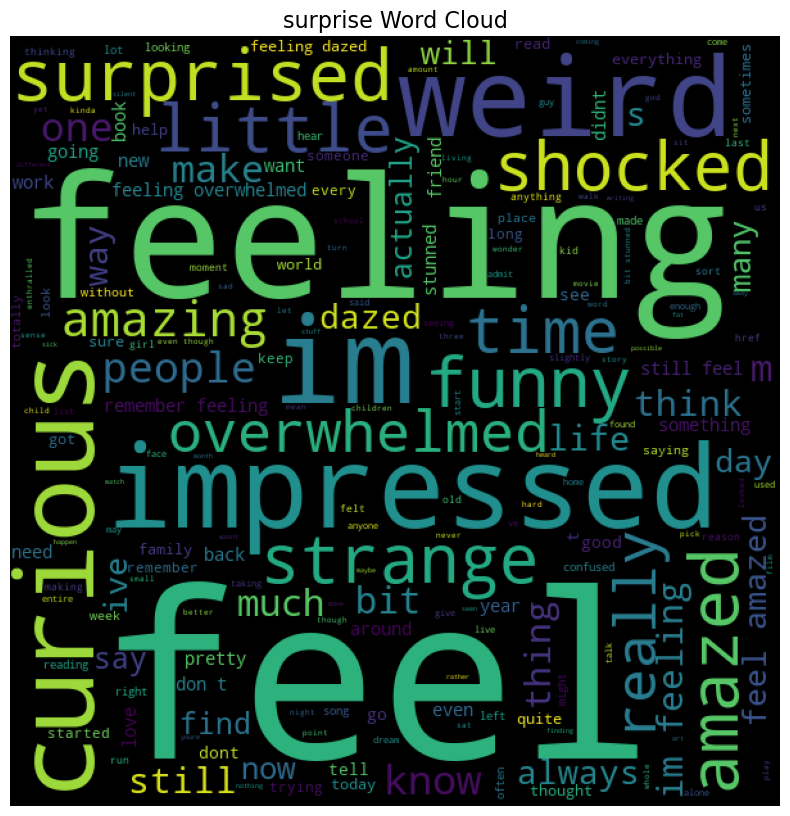

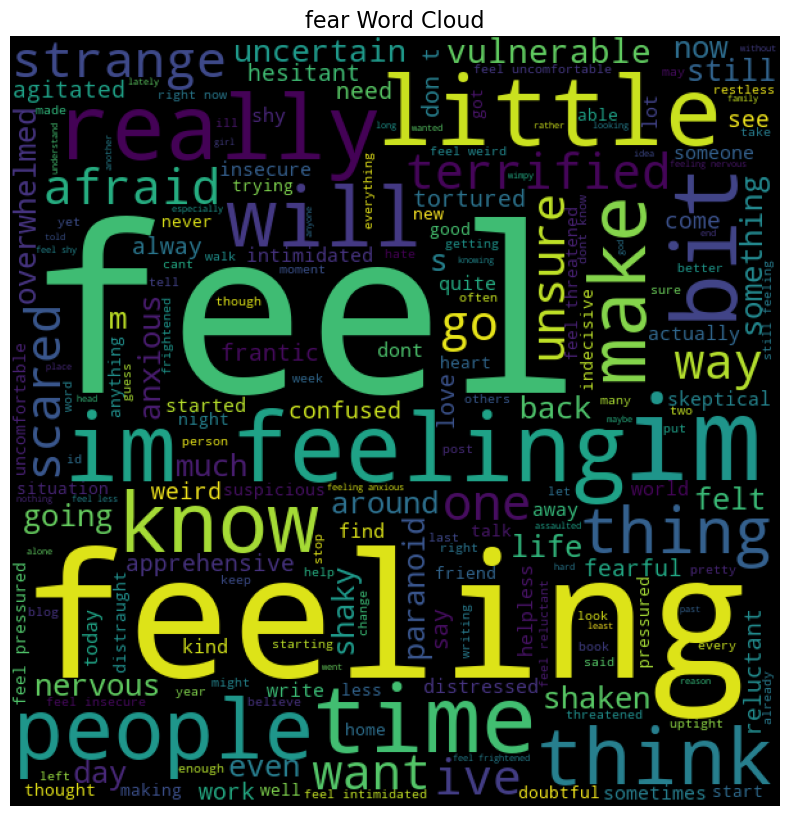

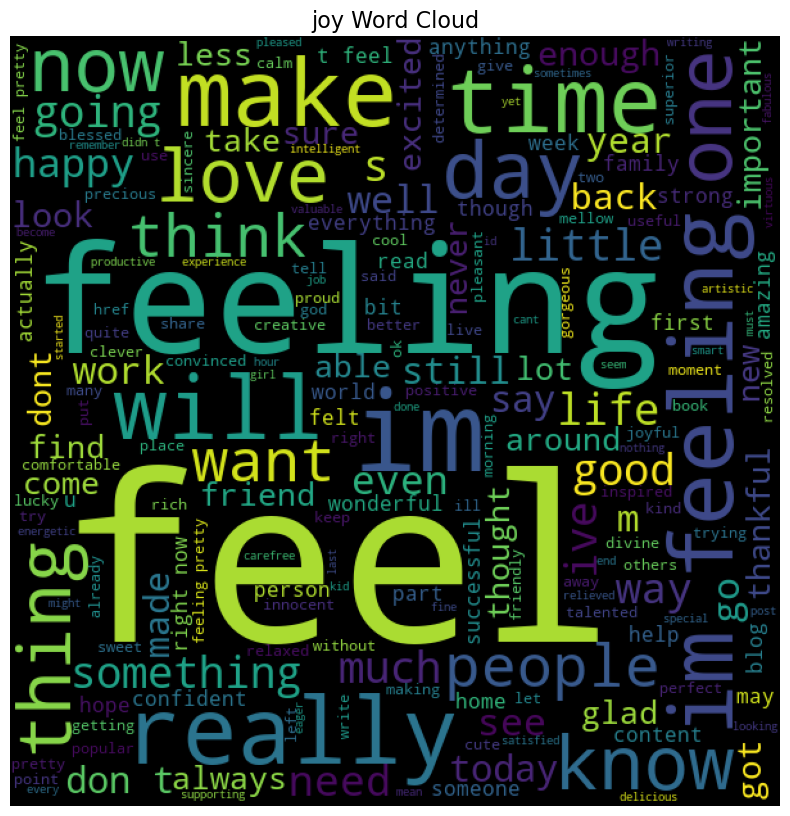

In [10]:
# Code to generate and display word clouds for each emotion

for emo in emo_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emo,'Text']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emo)

## Preprocessing

### In natural language processing, text data needs to be converted into numerical data before it can be fed into a machine learning algorithm. To do this, we start by tokenizing the text data using the Tokenizer() function from the Keras library. Tokenization is the process of converting text data into a sequence of tokens, where each token represents a single word or punctuation mark in the text.

### After tokenization, we need to pad the sequences to ensure that each sequence has the same length. This is done using the pad_sequences() function from the Keras library, which adds zeros to the beginning or end of each sequence as necessary to make them all the same length. The maximum length of the sequences is determined by the length of the longest sequence in the dataset.

### Next, we need to convert the class labels from strings to numerical values. This is done using the LabelEncoder() function from the scikit-learn library, which assigns a unique integer value to each class label. This allows the machine learning algorithm to work with numerical data.

### Finally, we need to one-hot encode the class labels. One-hot encoding is a technique for representing categorical data as binary vectors, where each vector has a 1 in the position corresponding to the class label and 0s elsewhere. This is done using the to_categorical() function from the Keras library.

### By completing these data preprocessing steps, we are gonna try to transform the raw text data into a format that can be used by a machine learning algorithm to predict the emotion class of a given text sample.

In [11]:
# Convert text data into sequences of tokens

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data["Text"])
sequences = tokenizer.texts_to_sequences(train_data["Text"])

In [12]:
# Pad the sequences to ensure each sequence has the same length

max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

In [13]:
# Convert the class labels from strings to numerical values

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(train_data["Emotion"])

In [14]:
# One-hot encode the class labels

one_hot_labels = to_categorical(labels)

In [15]:
# Split the data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, one_hot_labels, test_size=0.2)

## Model building

### Once the data has been preprocessed and transformed into numerical format, the next step is to train a machine learning model on the data. We'll be using a Sequential model from the Keras library for this task, which is a type of feedforward neural network.

### The model will be trained using the compiled optimizer "adam" and loss function "categorical_crossentropy". We'll also track the accuracy of the model during training.

### After training the model, we'll evaluate its performance. We'll plot the training and validation accuracy and loss curves to visualize the model's performance over the course of training.

### If necessary, we can implement early stopping during training to prevent overfitting and improve the model's performance. Once the model has been fully trained and evaluated, we can use it to make predictions on new text samples and classify them into one of the emotion categories.

In [16]:
# Define the model architecture

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, 
                    output_dim=128, input_length=max_length))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dense(units=len(one_hot_labels[0]), activation="softmax"))

# Compile the model

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 66, 128)           1947264   
                                                                 
 flatten (Flatten)           (None, 8448)              0         
                                                                 
 dense (Dense)               (None, 128)               1081472   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 3,029,510
Trainable params: 3,029,510
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Define early stopping callback

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [18]:
# Train the model

hist = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test), callbacks=[early_stop])

Epoch 1/5
200/200 [==============================] - 12s 57ms/step - loss: 1.4654 - accuracy: 0.4380 - val_loss: 1.1530 - val_accuracy: 0.5863
Epoch 2/5
200/200 [==============================] - 11s 54ms/step - loss: 0.5667 - accuracy: 0.8242 - val_loss: 0.5999 - val_accuracy: 0.8019
Epoch 3/5
200/200 [==============================] - 11s 54ms/step - loss: 0.1045 - accuracy: 0.9756 - val_loss: 0.5791 - val_accuracy: 0.8138
Epoch 4/5
200/200 [==============================] - 11s 56ms/step - loss: 0.0310 - accuracy: 0.9924 - val_loss: 0.6059 - val_accuracy: 0.8150
Epoch 5/5
200/200 [==============================] - 11s 55ms/step - loss: 0.0184 - accuracy: 0.9966 - val_loss: 0.6636 - val_accuracy: 0.8106


In [19]:
# Evaluate the model on the test set

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)

# Print the test loss and accuracy

print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

100/100 [==============================] - 0s 3ms/step - loss: 0.6636 - accuracy: 0.8106
Test loss: 0.6636202335357666
Test accuracy: 0.8106250166893005


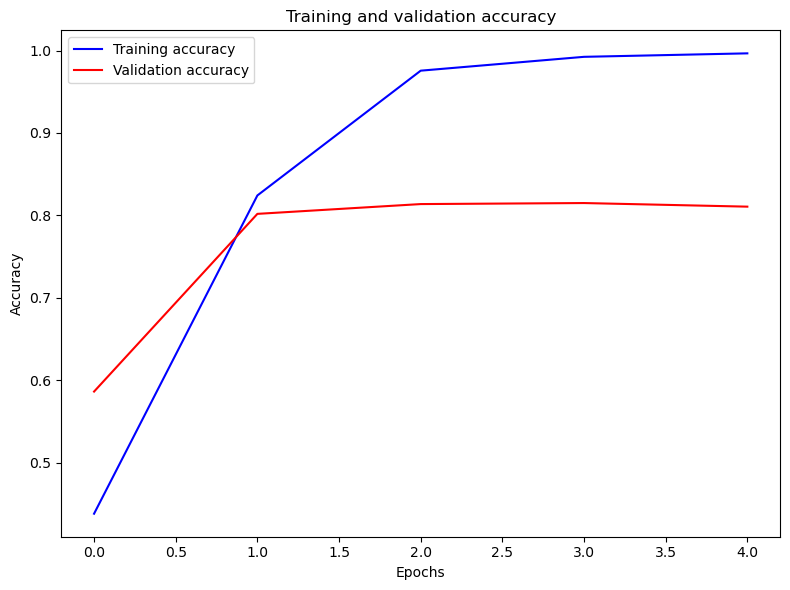

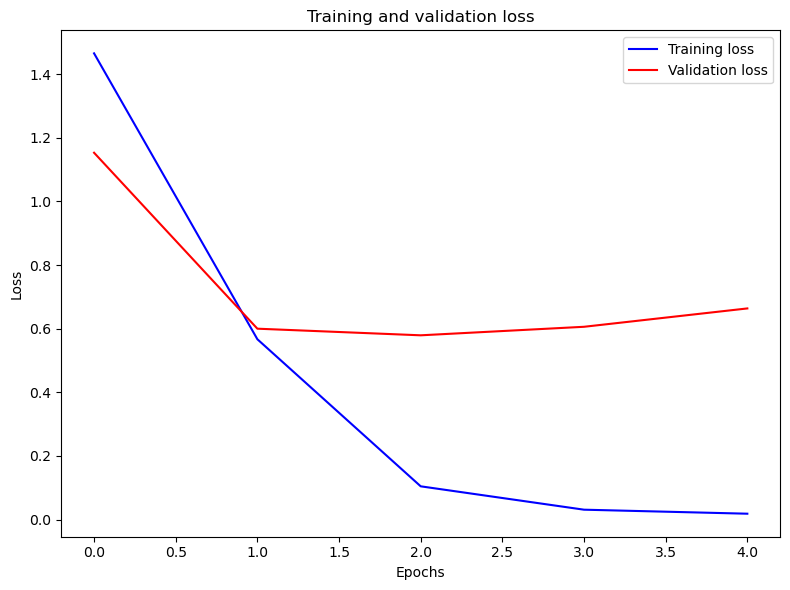

In [20]:
accuracy = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=range(len(accuracy))

# Plot training and validation accuracy

plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

# Plot training and validation loss

plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()

plt.show()

In [21]:
# Define the input text

input_text = "“I became insane, with long intervals of horrible sanity.”"

# Preprocess the input text

input_sequence = tokenizer.texts_to_sequences([input_text])
padded_input_sequence = pad_sequences(input_sequence, maxlen=max_length)

# Make prediction on the preprocessed input

prediction = model.predict(padded_input_sequence)

# Decode the predicted label

predicted_label_index = np.argmax(prediction[0])
predicted_label = label_encoder.inverse_transform([predicted_label_index])[0]

# Print the predicted label

print("The predicted emotion is:", predicted_label)

1/1 [==============================] - 0s 66ms/step
The predicted emotion is: sadness


## Summary

### In conclusion, we have successfully built a deep learning model for emotion recognition using natural language processing techniques. 

### We have preprocessed the text data by tokenizing and padding the sequences, and converting the class labels into numerical values using LabelEncoder() and one-hot encoding.

### We then trained the model on the preprocessed data, optimizing the hyperparameters to achieve the best performance. We also implemented early stopping to prevent overfitting and improve the model's generalization ability.

### Our evaluation results have shown that our model achieved a high accuracy on the validation set, indicating that it is able to effectively recognize the emotions in text data. This model can be used for various applications such as sentiment analysis and customer feedback analysis, and can be further improved by incorporating more advanced techniques and larger datasets.